# Visualize your Lookout for Equipment on QuickSight
## Introduction

The notebook generates all the necessary resources to bring your inference results and live data from Amazon Lookout for Equipment (L4E) to amazon Quickight to allow the building of visualizations. The services used in this notebook are:

-[Amazon Lookout for Equipment](https://aws.amazon.com/lookout-for-equipment/)

-[Amazon QuickSight](https://aws.amazon.com/quicksight/)

-[AWS Glue](https://aws.amazon.com/glue)

-[Amazon Athena](https://aws.amazon.com/athena)

-[Amazon S3](https://aws.amazon.com/s3/)

Amazon Lookout for Equipment is there to inference your live data and find abnormalities which are all stored in the Amazon S3. AWS Glue takes care of building the metadata of your data (inference results and live data) by using a crawler to understand your data and save the results as metadata tables in a Glue database. Amazon Athena is the bridge between Amazon QuickSight and Amazon S3 that allows QuickSight to query S3. Finally, Amazon QuickSight will allow the visualization of your data by building dashboards.


Note: 
This notebook allows you to bring your data to QuickSight but it does not support yet the automated building of dahsboards. Once you finish to follow this notebook, the data will be available in QuickSight for you to manually build your own dashboards.

## Prerequisites

To go through this notebook, you need to make sure to update the customer inputs section bellow according to your account/data.
You need to make sure that you are connected to your AWS account and that you have all the necessary permission to run the following API calls. 
This notebook considers that you already have a running L4E detector and will not go through on how to do it. If you do not have a running L4E detector, I invite you to follow the [L4E AWS sample](https://github.com/aws-samples/amazon-lookout-for-equipment) to create one . 
You need to have a QuickSight account. If you do not, go in the AWS console, go to QuickSight, and [create an account](https://docs.aws.amazon.com/quicksight/latest/user/signing-up.html). 

Note: 
You need an Amazon QuickSight enterprise account to run the API call to generate the analysis part. If you do not have an enterprise account and do not wish to have one, once you have created the dataset in this notebook, you can directly go to the console of QuickSight and generate in an easy 2 steps way an analysis of the dataset generated via this notebook. Instructions on how to do it are at the end of this notebook.

## Customer inputs

In [ ]:
#Where is located your S3 data: the data that L4E uses for inference (input), 
#and the result of the inference (output). You need the path location and the ARN.
inference_data_input_arn_s3=''
inference_data_output_arn_s3=''
inference_data_input_path_s3=''
inference_data_output_path_s3=''

#Update the user name according to yours (QuickSight username). You can find in the QuickSight console on the top right. 
#Update the region_L4E according to where is your L4E detector deployed.
#Update the region_user_Quicksight according to where you have created the QuickSight account that you will be using.
user_name = ''
region_user_Quicksight = ''
region_L4E=''

## Notebook start
### Importation of libraries and clients initialization

In [ ]:
import boto3
import os
import json
import RolesGeneratorL4E
import time

response = boto3.client('sts').get_caller_identity()
AwsAccountId=response['Account']
clientGlue = boto3.client('glue', region_name=region_L4E)
clientQuicksight = boto3.client('quicksight', region_name=region_user_Quicksight)
response = clientQuicksight.describe_user(
    UserName=user_name,
    AwsAccountId=AwsAccountId,
    Namespace='default'
)
user_ARN = response['User']['Arn']
clientQuicksight = boto3.client('quicksight', region_name=region_L4E)

### Role generator

In [ ]:
role_name_crawler=RolesGeneratorL4E.crawlerRoleCreation(inference_data_input_arn_s3,inference_data_output_arn_s3)

## Amazon Glue
#### Database creation

The following API will create a database in Glue in the region you specified previously. The database allows to store the metadata of the tables built by the crawler below. 

In [ ]:
response = clientGlue.create_database(
    DatabaseInput={
        'Name': 'L4E_from_coding',
        'Description': 'Database to visualize the L4E results on QuickSight'
    }
)

#### Crawler creation and start

The following API call will create the crawler and the one in the second cell will run the crawler. How long the crawler will take to go through your data and understand it will depend on the size and complexity of it. You need to wait the crawler to fininsh before proceding to the next steps/cells. 

In [ ]:
crawler_name='L4E_coding'
response = clientGlue.create_crawler(
    Name=crawler_name,
    Role= role_name_crawler,
    DatabaseName='L4E_from_coding',
    Description= 'Crawler created by coding to visualize L4E results',
    Targets={
        'S3Targets':[
            {
                'Path': inference_data_input_path_s3
            },
            {
                'Path': inference_data_output_path_s3
            }
        ]
    }
)


In [ ]:
clientGlue.start_crawler(Name=crawler_name)
finish=False
while finish==False:
    
    response = clientGlue.get_crawler(
        Name=crawler_name,        
    )
    if response['Crawler']['State']=='STOPPING':
        time.sleep(20)
        print('Crawler has finished')
        finish=True
    else:
        print('Crawler is running')
        time.sleep(10)

### Amazon QuickSight

The Amazon QuickSight into divided in 3 parts: the data source creation, the dataset creation and the analysis creation. As a reminder, starting from the analysis creation, you need an Amazon QuickSight enterprise account to do it via the notebook. If you do not have one, at the end of this notebook, there are the steps on how to create an analysis via the the Amazon QuickSight console

#### Datasource creation

In [ ]:
response_datasource = clientQuicksight.create_data_source(
    AwsAccountId=AwsAccountId,
    DataSourceId='L4ENotebook',
    Name='L4ENotebook',
    Type='ATHENA',
    Permissions=[
        {
            'Principal': user_ARN,
            'Actions': [               
                'quicksight:DescribeDataSource',
                'quicksight:DescribeDataSourcePermissions',
                'quicksight:UpdateDataSource',
                'quicksight:UpdateDataSourcePermissions',
                'quicksight:DeleteDataSource',
                'quicksight:PassDataSource',
            ]
        },
    ],
    
)

#### Dataset creation

Here is where you start generating the structure of your future tables. Following the API call crea_data_set() below, in the physical table map part we take the two tables generated by the crawler (input and output). For each we run a SQL query to restructure the table according to what we want to see. Once we have the two physical tables done, we join them as seen on the logical table map part.
If you want to adapt/change the input or output table (your live data used for inference by L4E), you have to adapt the SQL query in the inputCode part below from the physical table map part. 

In [ ]:
response_dataset = clientQuicksight.create_data_set(
    AwsAccountId=AwsAccountId,
    DataSetId='codingL4Eversion',
    Name='codingL4Eversion2',
    PhysicalTableMap={
        'outputCode': {
            'CustomSql': {
                'DataSourceArn': response_datasource['Arn'],
                'Name': 'outputCoding',
                'SqlQuery': "with dataset AS (SELECT timestamp,prediction, names FROM "+'"awesomebuilderpumpv2"."output" CROSS JOIN UNNEST(diagnostics) AS t(names)) SELECT  SPLIT_PART(timestamp,'+"'.'"+",1) AS timestamp, prediction, SPLIT_PART(names.name,'\\',1) AS subsystem, SPLIT_PART(names.name,'\\',2) AS sensor, names.value AS ScoreValue FROM dataset",
                'Columns': [
                    {
                        'Name': 'timestamp',
                        'Type': 'STRING'
                    },
                    {
                        'Name': 'prediction',
                        'Type': 'INTEGER'
                    },
                    {
                        'Name': 'subsystem',
                        'Type': 'STRING'
                    },
                    {
                        'Name': 'sensor',
                        'Type': 'STRING'
                    },
                    {
                        'Name': 'ScoreValue',
                        'Type': 'DECIMAL'
                    },

                ]                
            }          
        },
        'inputCode': {
            'CustomSql': {
                'DataSourceArn': response_datasource['Arn'],
                'Name': 'inputCoding',
                'SqlQuery': "SELECT SPLIT_PART(t1.timestamp,'.',1) AS timestamp, t2.sensor, t2.value FROM awesomebuilderpumpv2.input t1 CROSS JOIN unnest ( array['Sensor0', 'Sensor1', 'Sensor2','Sensor3', 'Sensor4', 'Sensor5','Sensor6', 'Sensor7', 'Sensor8','Sensor9', 'Sensor10', 'Sensor11','Sensor12', 'Sensor13', 'Sensor14','Sensor15', 'Sensor16', 'Sensor17','Sensor18', 'Sensor19', 'Sensor20','Sensor21','Sensor22','Sensor23', 'Sensor24', 'Sensor25', 'Sensor26', 'Sensor27', 'Sensor28', 'Sensor29'], array[sensor0, sensor1, sensor2, sensor3, sensor4, sensor5,sensor6, sensor7, sensor8,sensor9, sensor10, sensor11,sensor12, sensor13, sensor14,sensor15, sensor16, sensor17,sensor18, sensor19, sensor20,sensor21, sensor22, sensor23, sensor24, sensor25, sensor26, sensor27, sensor28, sensor29]) t2 (sensor, value)",
                'Columns': [
                    {
                        'Name': 'timestamp',
                        'Type': 'STRING'
                    },
                    {
                        'Name': 'sensor',
                        'Type': 'STRING'
                    },
                    {
                        'Name': 'value',
                        'Type': 'DECIMAL'
                    },
                ]                
            }            
        }
    },
    
    LogicalTableMap={
        'inputCode': {
            'Alias': 'alias inputCoding',
            'Source':{
                'PhysicalTableId': 'inputCode'
            },
            
        },
        'outputCode':{
            'Alias': 'outputCoding',
            'Source':{
                'PhysicalTableId': 'outputCode'
            },
            'DataTransforms': [
                {
                    'RenameColumnOperation': {
                        'ColumnName': 'timestamp',
                        'NewColumnName': 'timestampoutput'
                    }
                },
                {
                    'RenameColumnOperation': {
                        'ColumnName': 'sensor',
                        'NewColumnName': 'sensoroutput'
                    }
                },
               
            ],
        },
      
        'joinWithRight':{
            'Alias': 'RIGHT join of input and output',
            'Source': {
                'JoinInstruction': {
                    'LeftOperand': 'outputCode',
                    'RightOperand': 'inputCode',
                    'Type': 'RIGHT',
                    'OnClause': 'timestampoutput = timestamp AND sensoroutput=sensor'
                },
                
            },
            'DataTransforms': [
                {
                    'CreateColumnsOperation': {
                        'Columns': [
                            {
                                'ColumnName': 'timestampInput',
                                'ColumnId': 'calculatedTimestamp',
                                'Expression': 'parseDate(timestamp,"yyyy-MM-dd'+"'T'"+'HH:mm:ss")'
                            },
                        ]
                        
                    },
                },
                
                    {
                        'ProjectOperation': {
                            'ProjectedColumns': [
                                'timestampOutputFinal',
                                'timestampInput',
                                'value',
                                'sensor',
                                'subsystem',
                                'prediction',
                                'ScoreValue'
                        ]
                    }
                    }
     
                
    
            ],
        },
        
        
    },
    ImportMode='DIRECT_QUERY',    
    Permissions= [
      {
        'Principal': user_ARN,
        "Actions": [
                    "quicksight:DescribeDataSet",
                    "quicksight:DescribeDataSetPermissions",
                    "quicksight:PassDataSet",
                    "quicksight:DescribeIngestion",
                    "quicksight:ListIngestions",
                    'quicksight:UpdateDataSet',
            ]
        
      } 
    ],
)


#### Analysis creation with enterprise account

Warning: to run this cell you need an enterprise account. If you do not have one, skip this cell and go to the "Analysis creation without enterprise account"

In [ ]:
response_analysis = clientQuicksight.create_analysis(
    AwsAccountId=AwsAccountId,
    AnalysisId='L4E_Analysis',
    Name='Analysis of the L4E results',
    Permissions=[
        {
            'Principal': user_ARN,
            'Actions': [
                'quicksight:RestoreAnalysis', 
                'quicksight:UpdateAnalysisPermissions', 
                'quicksight:DeleteAnalysis', 
                'quicksight:QueryAnalysis', 
                'quicksight:DescribeAnalysisPermissions', 
                'quicksight:DescribeAnalysis', 
                'quicksight:UpdateAnalysis'
            ]
        },
    ],
    SourceEntity={
        'SourceTemplate': {
            'DataSetReferences': [
                {
                    'DataSetPlaceholder': 'L4E test template',
                    'DataSetArn': response_dataset['Arn']
                },
            ],
            'Arn': 'arn:aws:quicksight:us-east-1:165810815517:template/Template_L4E_Analysis'
        }
    },
)


#### Analysis creation without enterprise account
Go to the Amazon QuickSight console, make sure you are in the region where you created your dataset and select datasets, then follow below:

step 1:

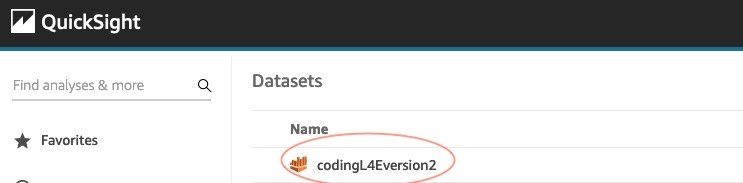

Step 2:

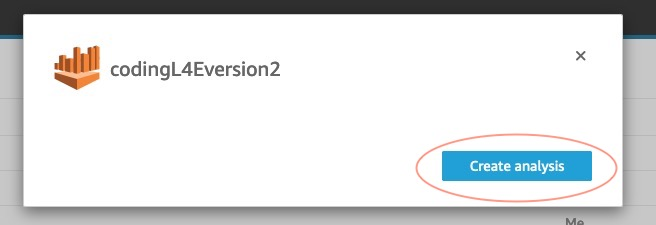

## Conclusion

You have successfully created a QuickSight analysis from L4E inference results and the live data. The data brought into QuickSight are:
- The *prediction* is 0 or 1 depending if L4E found an abnormality or not.
- The *scoreValue* represents the value from L4E that tells you the percentage of how much each sensor is affecting the abnomarlity detected. 
- The *sensor* is the sensor name. 
- The *subsystem* represents the name of the subsystem to which the sensor belongs.
- The *timestampinput* represents the time from the live data (the data brought into S3 to be analyzed by L4E).
- The *value* is the value itself of the sensor. It represents the value of the sensor in the live data. 

The next step is to build the dashboards of the data you would like to see. There are plenty of resources that teaches you how to do it. I would recommend to start the following:

[Amazon QuickSight workshop](https://learnquicksight.workshop.aws/en/)


[Amazon QuickSight documentation](https://docs.aws.amazon.com/quicksight/latest/user/working-with-analyses.html)

Examples of visualizations:


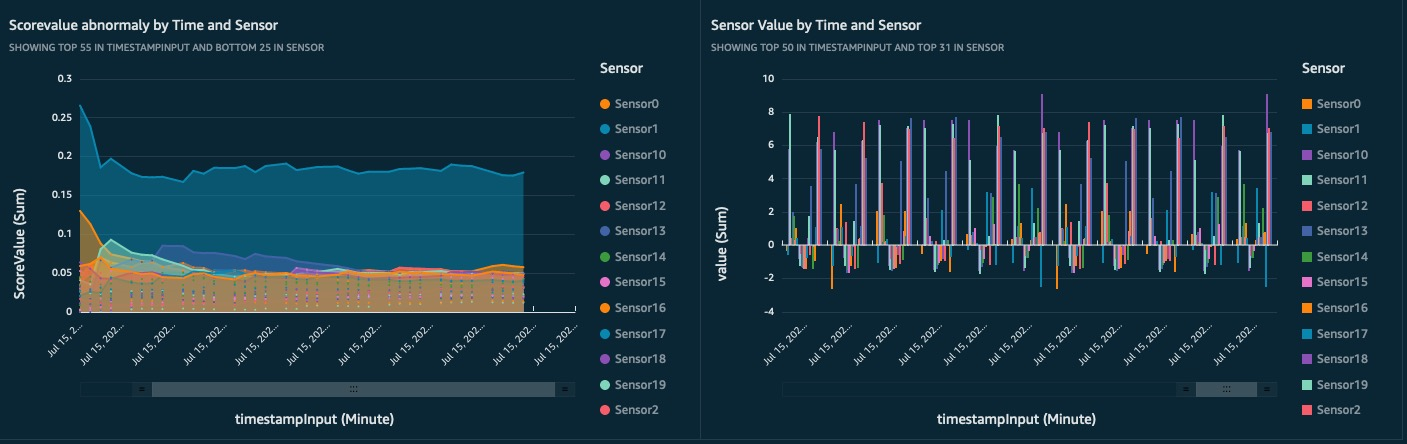


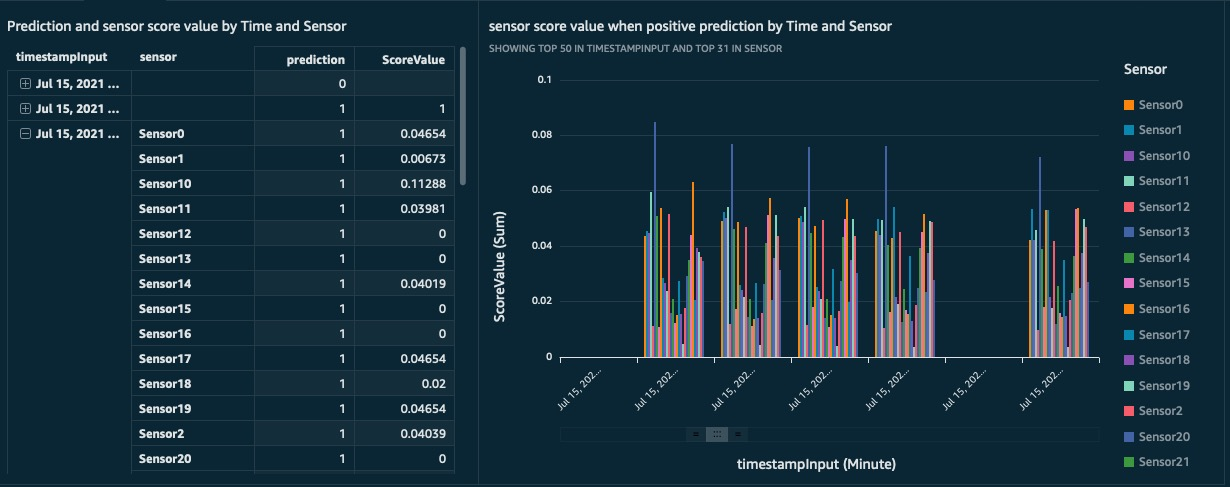